# Chapter 7
# 신경망 , 딥러닝

> ## 머신러닝(지도학습)
> 선형회귀모델
> 선형 기저 함수 모델
> 로지스틱 회귀 모델
> 서포트 벡터 머신
>> ## 신경망 모델
>> 2층 피드 포워드 네트워크
>> 합성곱 네트워크
>> 전결합형 네트워크
>>> ## 딥러닝(심층학습)
>>> 10층 피드 포워드 네트워크
>>> 합성곱 네트워크
>>> 전결합형 네트워크

# 7.1 뉴런모델

## 7.1.1 신경세포

## 7.1.2 뉴런모델

x = 입력
w = 가중치(입력에대한 시밴스 전달 강도)
$$ a = w_0x_0 +w_1x_1 +w_2$$

$w_2$는 절편을 나타내는 매개변수이다

항상 1 을 갖는 입력 x_2을 가정하고 

$$ a = w_0x_0 +w_1x_1 +w_2x_2$$

식을 만든다. 입력 차원을 D차원이라고 가정하고 이 식을 시그마로 정리하면

$$ a = \sum_{i=0}^D w_ix_i$$

이된다

입력 총 합에 시그모이드 함수를 적용하면

$$ y = 1/(1+exp(-a)) $$

y 는 0 부터 1 까지 연속된 값을 가진다


> D 차원의 입력 공간을 D-1차원 평면에서 2개로 나눈다고 할 수 있다

# 7.2 신경망 모델

## 7.2.1 2층 피드 포워드 신경망

뉴런모델은 입력 공산을 선으로 나눈다는 단순한 기능밖에 없지만, 이를 조합하면 강력하게 이용할 수 있다

이러한 뉴런의 집합체 모델을 신경망 모델이라고 한다



## 7.2.2 2층 피드 포워드 신경망의 구현

In [48]:
#-- 리스트 7-1-(1)
import numpy as np
# 데이터 생성 --------------------------------
np.random.seed(seed=1) # 난수를 고정
N = 200 # 데이터의 수
K = 3 # 분포의 수
T = np.zeros((N, 3), dtype=np.uint8)
X = np.zeros((N, 2))
X_range0 = [-3, 3] # X0의 범위, 표시용
X_range1 = [-3, 3] # X1의 범위, 표시용
Mu = np.array([[-.5, -.5], [.5, 1.0], [1, -.5]]) # 분포의 중심
Sig = np.array([[.7, .7], [.8, .3], [.3, .8]]) # 분포의 분산
Pi = np.array([0.4, 0.8, 1]) # 각 분포에 대한 비율
for n in range(N):
    wk = np.random.rand()
    for k in range(K):
        if wk < Pi[k]:
            T[n, k] = 1
            break
    for k in range(2):
        X[n, k] = np.random.randn() * Sig[T[n, :] == 1, k] + \
        Mu[T[n, :] == 1, k]

In [49]:
#-- 리스트 7-1-(2)
# -------- 2 분류 데이터를 테스트 훈련 데이터로 분할
TestRatio = 0.5
X_n_training = int(N * TestRatio)
X_train = X[:X_n_training, :]
X_test = X[X_n_training:, :]
T_train = T[:X_n_training, :]
T_test = T[X_n_training:, :]


# -------- 데이터를 'class_data.npz'에 저장
np.savez('class_data.npz', X_train=X_train, T_train=T_train,
         X_test=X_test, T_test=T_test,
         X_range0=X_range0, X_range1=X_range1)

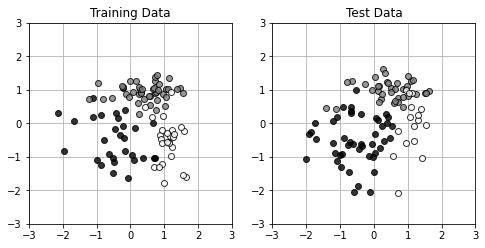

In [50]:
#-- 리스트 7-1-(3)
import matplotlib.pyplot as plt
%matplotlib inline


# 데이터를 그리기 ------------------------------
def Show_data(x, t):
    wk, n = t.shape
    c = [[0, 0, 0], [.5, .5, .5], [1, 1, 1]]
    for i in range(n):
        plt.plot(x[t[:, i] == 1, 0], x[t[:, i] == 1, 1],
                 linestyle='none',
                 marker='o', markeredgecolor='black',
                 color=c[i], alpha=0.8)
    plt.grid(True)


# 메인 ------------------------------------
plt.figure(1, figsize=(8, 3.7))
plt.subplot(1, 2, 1)
Show_data(X_train, T_train)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Training Data')
plt.subplot(1, 2, 2)
Show_data(X_test, T_test)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Test Data')
plt.show()

In [51]:
# 리스트 7-1-(4)
# 시그모이드 함수 ------------------------
def Sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    return y


# 네트워크 ------------------------
def FNN(wv, M, K, x):
    N, D = x.shape # 입력 차원
    w = wv[:M * (D + 1)] # 중간층 뉴런의 가중치
    w = w.reshape(M, (D + 1))
    v = wv[M * (D + 1):] # 출력층 뉴런의 가중치
    v = v.reshape((K, M + 1))
    b = np.zeros((N, M + 1)) # 중간층 뉴런의 입력 총합
    z = np.zeros((N, M + 1)) # 중간층 뉴런의 출력
    a = np.zeros((N, K)) # 출력층 뉴런의 입력 총합
    y = np.zeros((N, K)) # 출력층 뉴런의 출력
    for n in range(N):
        # 중간층의 계산
        for m in range(M):
            b[n, m] = np.dot(w[m, :], np.r_[x[n, :], 1]) # (A)
            z[n, m] = Sigmoid(b[n, m])
        # 출력층의 계산
        z[n, M] = 1 # 더미 뉴런
        wkz = 0
        for k in range(K):
            a[n, k] = np.dot(v[k, :], z[n, :])
            wkz = wkz + np.exp(a[n, k])
        for k in range(K):
            y[n, k] = np.exp(a[n, k]) / wkz
    return y, a, z, b


# test ---
WV = np.ones(15)
M = 2
K = 3
FNN(WV, M, K, X_train[:2, :])

(array([[0.33333333, 0.33333333, 0.33333333],
        [0.33333333, 0.33333333, 0.33333333]]),
 array([[2.6971835 , 2.6971835 , 2.6971835 ],
        [1.49172649, 1.49172649, 1.49172649]]),
 array([[0.84859175, 0.84859175, 1.        ],
        [0.24586324, 0.24586324, 1.        ]]),
 array([[ 1.72359839,  1.72359839,  0.        ],
        [-1.12079826, -1.12079826,  0.        ]]))

# _after

네트워크함수 설계시 특징
- N개의 데이터를 한꺼번에 처리하도록 설계
- Network의 parameter: 중간층 뉴런의 수(M), 출력의 차원 수(K)
- 중간층의 bias neuron을 고려: 중간층 가중치 W는 M (D+1)행렬, V는 K (M+1) 행렬
- W와 V의 정보는 둘을 하나로합친벡터 WV로 전달



## 7.2.3 수치 미분법

<!-- #### -->

수치미분의 단점은 정밀도의 오차보다는 계산비용에 있다.

한 매개 변수의 미분을 계산하기위해 매개변수 하나에 두번의 E 계산이 필요하기 때문이다.

In [52]:
# 리스트 7-1-(5)
# 평균 교차 엔트로피 오차 ---------
def CE_FNN(wv, M, K, x, t):
    N, D = x.shape
    y, a, z, b = FNN(wv, M, K, x)
    ce = -np.dot(np.log(y.reshape(-1)), t.reshape(-1)) / N
    return ce


# test ---
WV = np.ones(15)
M = 2
K = 3
CE_FNN(WV, M, K, X_train[:2, :], T_train[:2, :])

1.0986122886681098

[ 0.0884813   0.19157999 -0.05139799  0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115648 -0.10104422 -0.09427964 -0.46855603
  0.13096434  0.08076649  0.57971252]


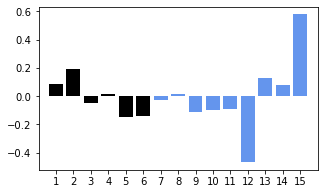

In [53]:
# 리스트 7-1-(6)
# - 수치 미분 ------------------
def dCE_FNN_num(wv, M, K, x, t):
    epsilon = 0.001
    dwv = np.zeros_like(wv)
    for iwv in range(len(wv)):
        wv_modified = wv.copy()
        wv_modified[iwv] = wv[iwv] - epsilon
        mse1 = CE_FNN(wv_modified, M, K, x, t)
        wv_modified[iwv] = wv[iwv] + epsilon
        mse2 = CE_FNN(wv_modified, M, K, x, t)
        dwv[iwv] = (mse2 - mse1) / (2 * epsilon)
    return dwv


#--dVW의 표시 ------------------
def Show_WV(wv, M):
    N = wv.shape[0]
    plt.bar(range(1, M * 3 + 1), wv[:M * 3], align="center", color='black')
    plt.bar(range(M * 3 + 1, N + 1), wv[M * 3:],
            align="center", color='cornflowerblue')
    plt.xticks(range(1, N + 1))
    plt.xlim(0, N + 1)


#-test----
M = 2
K = 3
nWV = M * 3 + K * (M + 1)
np.random.seed(1)
WV = np.random.normal(0, 1, nWV)
dWV = dCE_FNN_num(WV, M, K, X_train[:2, :], T_train[:2, :])
print(dWV)
plt.figure(1, figsize=(5, 3))
Show_WV(dWV, M)
plt.show()

## 7.2.4 수치 미분법에 의한 경사 하강법

In [54]:
# 리스트 7-1-(7)
import time


# 수치 미분을 사용한 구배법 -------
def Fit_FNN_num(wv_init, M, K, x_train, t_train, x_test, t_test, n, alpha):
    wvt = wv_init
    err_train = np.zeros(n)
    err_test = np.zeros(n)
    wv_hist = np.zeros((n, len(wv_init)))
    epsilon = 0.001
    for i in range(n): # (A)
        wvt = wvt - alpha * dCE_FNN_num(wvt, M, K, x_train, t_train)
        err_train[i] = CE_FNN(wvt, M, K, x_train, t_train)
        err_test[i] = CE_FNN(wvt, M, K, x_test, t_test)
        wv_hist[i, :] = wvt
    return wvt, wv_hist, err_train, err_test


# 메인 ---------------------------
startTime = time.time()
M = 2
K = 3
np.random.seed(1)
WV_init = np.random.normal(0, 0.01, M * 3 + K * (M + 1))
N_step = 1000 # (B) 학습 단계
alpha = 0.5
WV, WV_hist, Err_train, Err_test = Fit_FNN_num(
    WV_init, M, K, X_train, T_train, X_test, T_test, N_step, alpha)
calculation_time = time.time() - startTime
print("Calculation time:{0:.3f} sec".format(calculation_time))

Calculation time:203.355 sec


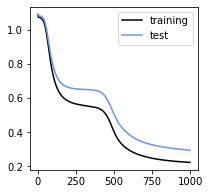

In [55]:
# 리스트 7-1-(8)
# 학습 오차의 표시 ---------------------------
plt.figure(1, figsize=(3, 3))
plt.plot(Err_train, 'black', label='training')
plt.plot(Err_test, 'cornflowerblue', label ='test')
plt.legend()
plt.show()

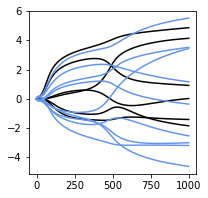

In [56]:
# 리스트 7-1-(9)
# 가중치의 시간 변화의 표시 ---------------------------
plt.figure(1, figsize=(3, 3))
plt.plot(WV_hist[:, :M * 3], 'black')
plt.plot(WV_hist[:, M * 3:], 'cornflowerblue')
plt.show()

0 주변의 기본값으로 시작된 가중치는 각각 특정 값으로 서서히 수렴하고 있다.

400단계 부근에서 각각의 가중치 그래프가 교차하는것을 볼 수 있다
- 가중치를 갱신하는 방향, 오차함수의 기울기 방향이 변화하는 것을 의미한다. (가중치가 안장점을 통과할 때 이러한 경향을 보인다)

-> 학습의 진행은 안장점 부근에서 느려지고, 안장점을 통과하면 학습의 방향이 바뀐다

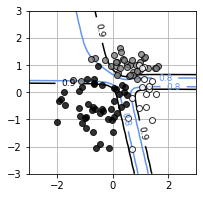

In [57]:
# 리스트 7-1-(10)
# 경계선 표시 함수 --------------------------
def show_FNN(wv, M, K):
    xn = 60 # 등고선 표시 해상도
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    x = np.c_[np.reshape(xx0, xn * xn, 'F'), np.reshape(xx1, xn * xn, 'F')]
    y, a, z, b = FNN(wv, M, K, x)
    plt.figure(1, figsize=(4, 4))
    for ic in range(K):
        f = y[:, ic]
        f = f.reshape(xn, xn)
        f = f.T
        cont = plt.contour(xx0, xx1, f, levels=[0.8, 0.9],
                           colors=['cornflowerblue', 'black'])
        cont.clabel(fmt='%1.1f', fontsize=9)
    plt.xlim(X_range0)
    plt.ylim(X_range1)
    
    
# 경계선 표시 --------------------------
plt.figure(1, figsize=(3, 3))
Show_data(X_test, T_test)
show_FNN(WV, M, K)
plt.show()

## 7.2.5 오차 역전파법

가중치 학습법칙

$w_{ji}(t+1) = w_{ji} - \alpha \delta_j x_i$

$\delta$ 는 upstream gradient 의 sum

$\alpha$ 는 learning rate

$x$ 는 현재 node를 가중치로 편미분한 값

---

네트워크의 매개변수 갱신방법

1. 네트워크에 x를 입력하고 출력 y 를 얻는다. 이때 중간에 계산된  b, z ,a 를 보유해둔다
2. 출력 y를 목표데이터 t와 비교해 그 차이(오차)를 계산한다. 이 오차는 출력층의 각 뉴련에 할당 된다고 생각한다
3. 출력층의 오차를 사용하여 중간층의 오차를 계산한다.
4. 결합 본래의 신호 강도와 결합처의 오차 정보를 사용하여 가중치 매개변수를 갱신한다

# _after

### back propagation

가중치 갱신법칙
$w_{t+1} = w_{t} * (upstream gradient) * (local gradient) $

upstream gradient 는 gradient flow를 따라 loss로 부터 현재 update 하려는 node 까지의 chain rule에 의한 값을 구한다
- 뒤에서 두번째 node의 upstream gradient = $\frac{\partial (\delta_1)}{ \partial (\delta_2)} \frac{\partial E}{ \partial (\delta_1)}$
- 뒤에서 첫번째 node의 upstream gradient = $ \frac{\partial E}{ \partial (\delta_1)}$
- $\delta_i$  는 뒤에서 몇번째 활성함수인지 마지막 활성함수는 $ loss(\delta_{1}(입력)) $으로 취급한다


local gradient는 현재 node에 입력되는 값 (w x) 를 가중치(w) 로 편미분하여 구한다 
- wx 의 경우 local gradient가 x 가 된다

## 7.2.6 $dE_n/dv_{kj}$를 구하기

## 7.2.7 $dE_n/dw_{ji}$를 구하기

## 7.2.8 오차 역전파법의 구현

analytical dWV
[ 0.08848131  0.19158    -0.051398    0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115649 -0.10104422 -0.09427964 -0.46855604
  0.13096434  0.08076649  0.57971253]
numerical dWV
[ 0.0884813   0.19157999 -0.05139799  0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115648 -0.10104422 -0.09427964 -0.46855603
  0.13096434  0.08076649  0.57971252]


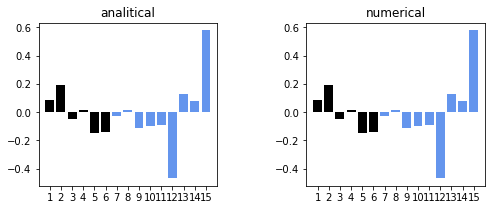

In [58]:
# 리스트 7-1-(11)
# -- 해석적 미분 -----------------------------------
def dCE_FNN(wv, M, K, x, t):
    N, D = x.shape
    # wv을 w와 v로 되돌림
    w = wv[:M * (D + 1)]
    w = w.reshape(M, (D + 1))
    v = wv[M * (D + 1):]
    v = v.reshape((K, M + 1))
    # ① x를 입력하여 y를 얻음
    y, a, z, b = FNN(wv, M, K, x)
    # 출력 변수의 준비
    dwv = np.zeros_like(wv)
    dw = np.zeros((M, D + 1))
    dv = np.zeros((K, M + 1))
    delta1 = np.zeros(M) # 1층 오차
    delta2 = np.zeros(K) # 2층 오차(k = 0 부분은 사용하지 않음)
    for n in range(N): # (A)
        # ② 출력층의 오차를 구하기
        for k in range(K):
            delta2[k] = (y[n, k] - t[n, k])
        # ③ 중간층의 오차를 구하기
        for j in range(M):
            delta1[j] = z[n, j] * (1 - z[n, j]) * np.dot(v[:, j], delta2)
        # ④ v의 기울기 dv를 구하기
        for k in range(K):
            dv[k, :] = dv[k, :] + delta2[k] * z[n, :] / N
        # ④ w의 기울기 dw를 구하기
        for j in range(M):
            dw[j, :] = dw[j, :] + delta1[j] * np.r_[x[n, :], 1] / N
    # dw와 dv를 합체시킨 dwv로 만들기
    dwv = np.c_[dw.reshape((1, M * (D + 1))), \
                dv.reshape((1, K * (M + 1)))]
    dwv = dwv.reshape(-1)
    return dwv


#------Show VW
def Show_dWV(wv, M):
    N = wv.shape[0]
    plt.bar(range(1, M * 3 + 1), wv[:M * 3],
            align="center", color='black')
    plt.bar(range(M * 3 + 1, N + 1), wv[M * 3:],
            align="center", color='cornflowerblue')
    plt.xticks(range(1, N + 1))
    plt.xlim(0, N + 1)
    
    
#-- 동작 확인
M = 2
K = 3
N = 2
nWV = M * 3 + K * (M + 1)
np.random.seed(1)
WV = np.random.normal(0, 1, nWV)


dWV_ana = dCE_FNN(WV, M, K, X_train[:N, :], T_train[:N, :])
print("analytical dWV")
print(dWV_ana)


dWV_num = dCE_FNN_num(WV, M, K, X_train[:N, :], T_train[:N, :])
print("numerical dWV")
print(dWV_num)


plt.figure(1, figsize=(8, 3))
plt.subplots_adjust(wspace=0.5)
plt.subplot(1, 2, 1)
Show_dWV(dWV_ana, M)
plt.title('analitical')
plt.subplot(1, 2, 2)
Show_dWV(dWV_num, M)
plt.title('numerical')
plt.show()

# _after

수치적 방법과 해석적 방법 둘 다 값은 동일하게 나오지만 

시간은 해석적인 방법에서 더 빠르다

In [59]:
# 리스트 7-1-(12)
import time


# 해석적 미분을 사용한 구배법 -------
def Fit_FNN(wv_init, M, K, x_train, t_train, x_test, t_test, n, alpha):
    wv = wv_init.copy()
    err_train = np.zeros(n)
    err_test = np.zeros(n)
    wv_hist = np.zeros((n, len(wv_init)))
    epsilon = 0.001
    for i in range(n):
        wv = wv - alpha * dCE_FNN(wv, M, K, x_train, t_train) # (A)
        err_train[i] = CE_FNN(wv, M, K, x_train, t_train)
        err_test[i] = CE_FNN(wv, M, K, x_test, t_test)
        wv_hist[i, :] = wv
    return wv, wv_hist, err_train, err_test


# 메인 ---------------------------
startTime = time.time()
M = 2
K = 3
np.random.seed(1)
WV_init = np.random.normal(0, 0.01, M * 3 + K * (M + 1))
N_step = 1000
alpha = 1
WV, WV_hist, Err_train, Err_test = Fit_FNN(
    WV_init, M, K, X_train, T_train, X_test, T_test, N_step, alpha)
calculation_time = time.time() - startTime
print("Calculation time:{0:.3f} sec".format(calculation_time))

Calculation time:27.276 sec


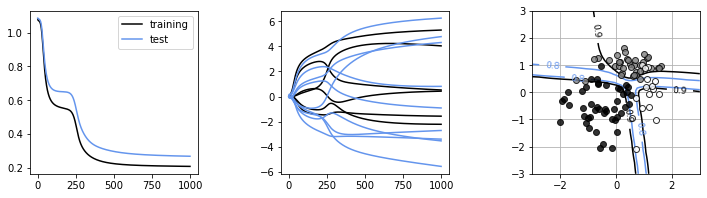

In [60]:
# 리스트 7-1-(13)
plt.figure(1, figsize=(12, 3))
plt.subplots_adjust(wspace=0.5)
# 학습 오차의 표시 ---------------------------
plt.subplot(1, 3, 1)
plt.plot(Err_train, 'black', label='training')
plt.plot(Err_test, 'cornflowerblue', label='test')
plt.legend()
# 가중치의 시간 변화 표시 ---------------------------
plt.subplot(1, 3, 2)
plt.plot(WV_hist[:, :M * 3], 'black')
plt.plot(WV_hist[:, M * 3:], 'cornflowerblue')
# 경계선 표시 --------------------------
plt.subplot(1, 3, 3)
Show_data(X_test, T_test)
M = 2
K = 3
show_FNN(WV, M, K)
plt.show()

## 7.2.9 학습 후 뉴런의 특성

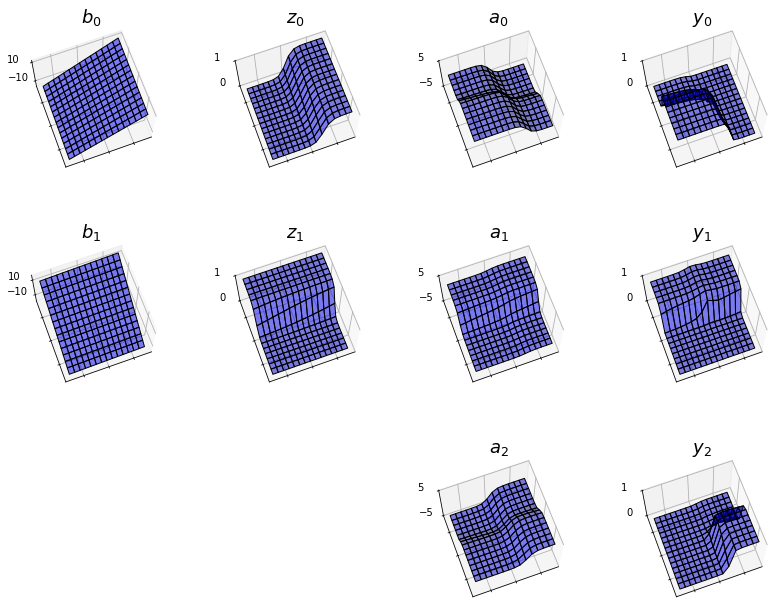

In [61]:
# 리스트 7-1-(14)
from mpl_toolkits.mplot3d import Axes3D


def show_activation3d(ax, v, v_ticks, title_str):
    f = v.copy()
    f = f.reshape(xn, xn)
    f = f.T
    ax.plot_surface(xx0, xx1, f, color='blue', edgecolor='black',
                    rstride=1, cstride=1, alpha=0.5)
    ax.view_init(70, -110)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticks(v_ticks)
    ax.set_title(title_str, fontsize=18)
    
    
M = 2
K = 3
xn = 15 # 등고선 표시 해상도
x0 = np.linspace(X_range0[0], X_range0[1], xn)
x1 = np.linspace(X_range1[0], X_range1[1], xn)
xx0, xx1 = np.meshgrid(x0, x1)
x = np.c_[np.reshape(xx0, xn * xn, 'F'), np.reshape(xx1, xn * xn, 'F')]
y, a, z, b = FNN(WV, M, K, x)


fig = plt.figure(1, figsize=(12, 9))
plt.subplots_adjust(left=0.075, bottom=0.05, right=0.95,
                    top=0.95, wspace=0.4, hspace=0.4)

for m in range(M):
    ax = fig.add_subplot(3, 4, 1 + m * 4, projection='3d')
    show_activation3d(ax, b[:, m], [-10, 10], '$b_{0:d}$'.format(m))
    ax = fig.add_subplot(3, 4, 2 + m * 4, projection='3d')
    show_activation3d(ax, z[:, m], [0, 1], '$z_{0:d}$'.format(m))
    
    
for k in range(K):
    ax = fig.add_subplot(3, 4, 3 + k * 4, projection='3d')
    show_activation3d(ax, a[:, k], [-5, 5], '$a_{0:d}$'.format(k))
    ax = fig.add_subplot(3, 4, 4 + k * 4, projection='3d')
    show_activation3d(ax, y[:, k], [0, 1], '$y_{0:d}$'.format(k))


plt.show()

# 7.3 케라스로 신경망 모델 구현

## 7.3.1 2층 피드 포워드 신경망

In [62]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [63]:
# 리스트 7-2-(1)
import numpy as np
import matplotlib.pyplot as plt
import time
np.random.seed(1) # (A)
import keras.optimizers # (B)
from keras.models import Sequential # (C)
from keras.layers.core import Dense, Activation #(D)
import tensorflow


# 데이터 로드 ---------------------------
outfile = np.load('class_data.npz')
X_train = outfile['X_train']
T_train = outfile['T_train']
X_test = outfile['X_test']
T_test = outfile['T_test']
X_range0 = outfile['X_range0']
X_range1 = outfile['X_range1']

In [64]:
# 리스트 7-2-(2)
# 데이터를 그리기 ------------------------------
def Show_data(x, t):
    wk, n = t.shape
    c = [[0, 0, 0], [.5, .5, .5], [1, 1, 1]]
    for i in range(n):
        plt.plot(x[t[:, i] == 1, 0], x[t[:, i] == 1, 1],
                 linestyle='none', marker='o',
                 markeredgecolor='black',
                 color=c[i], alpha=0.8)
    plt.grid(True)

In [65]:
# 리스트 7-2-(3)
# 난수 초기화
np.random.seed(1)


# --- Sequential 모델 작성
model = Sequential()
model.add(Dense(2, input_dim=2, activation='sigmoid',
                kernel_initializer='uniform')) # (A)
model.add(Dense(3,activation='softmax',
                kernel_initializer='uniform')) # (B)
sgd = tensorflow.keras.optimizers.SGD(lr=1, momentum=0.0,
                           decay=0.0, nesterov=False) # (C)
model.compile(optimizer=sgd, loss='categorical_crossentropy',
              metrics=['accuracy']) # (D)


# ---------- 학습
startTime = time.time()
history = model.fit(X_train, T_train, epochs=1000, batch_size=100,
                    verbose=0, validation_data=(X_test, T_test)) # (E)


# ---------- 모델 평가
score = model.evaluate(X_test, T_test, verbose=0) # (F)
print('cross entropy {0:3.2f}, accuracy {1:3.2f}'\
      .format(score[0], score[1]))
calculation_time = time.time() - startTime
print("Calculation time:{0:.3f} sec".format(calculation_time))

C:\Users\song1248\AppData\Roaming\Python\Python38\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


cross entropy 0.26, accuracy 0.90
Calculation time:29.359 sec


## 7.3.2 케라스 사용의 흐름

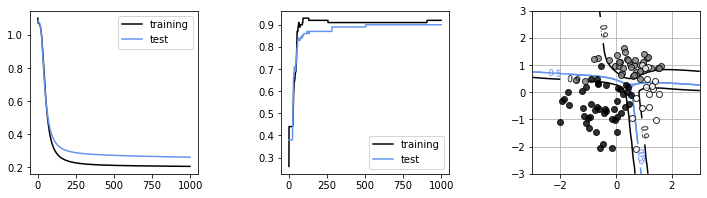

In [68]:
# 리스트 7-2-(4)
plt.figure(1, figsize = (12, 3))
plt.subplots_adjust(wspace=0.5)


# 학습 곡선 표시 --------------------------
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], 'black', label='training') # (A)
plt.plot(history.history['val_loss'], 'cornflowerblue', label='test') # (B)
plt.legend()


# 정확도 표시 --------------------------
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], 'black', label='training') # (C)
plt.plot(history.history['val_accuracy'], 'cornflowerblue', label='test') # (D)
plt.legend()


# 경계선 표시 --------------------------
plt.subplot(1, 3, 3)
Show_data(X_test, T_test)
xn = 60 # 등고선 표시 해상도
x0 = np.linspace(X_range0[0], X_range0[1], xn)
x1 = np.linspace(X_range1[0], X_range1[1], xn)
xx0, xx1 = np.meshgrid(x0, x1)
x = np.c_[np.reshape(xx0, xn * xn, 'F'), np.reshape(xx1, xn * xn, 'F')]
y = model.predict(x) # (E)
K = 3
for ic in range(K):
    f = y[:, ic]
    f = f.reshape(xn, xn)
    f = f.T
    cont = plt.contour(xx0, xx1, f, levels=[0.5, 0.9], colors=[
        'cornflowerblue', 'black'])
    cont.clabel(fmt='%1.1f', fontsize=9)
    plt.xlim(X_range0)
    plt.ylim(X_range1)
plt.show()

# chapter 8
# 신경망, 딥러닝의 응용(필기체 숫자 인식)

## 8.1 MNIST 데이터베이스

In [69]:
#-- 리스트 8-1-(1)
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

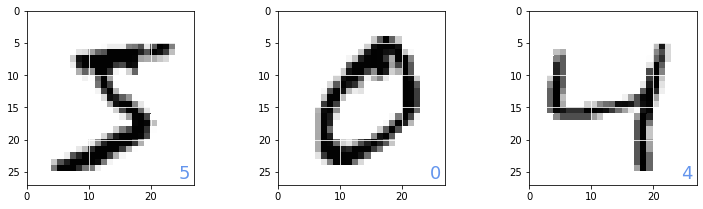

In [70]:
# - 리스트 8-1-(2)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(1, figsize=(12, 3.2))
plt.subplots_adjust(wspace=0.5)
plt.gray()
for id in range(3):
    plt.subplot(1, 3, id + 1)
    img = x_train[id, :, :]
    plt.pcolor(255 - img)
    plt.text(24.5, 26, "%d" % y_train[id],
             color='cornflowerblue', fontsize=18)
    plt.xlim(0, 27)
    plt.ylim(27, 0)
    plt.grid('on', color='white')
plt.show()

## 8.2 2층 피드 포워드 네트워크 모델

28 * 28 의 이미지 데이터를 784 길이의 벡터로 처리한다.
- 60000 * 28 * 28 의 배열을 60000 * 784 의 배열로 변환한다

입력은 실수로 처리하고 싶음으로 int를 float형으로 변환한한다

입력을 255로 나누어, 0 ~ 1 의 실수로 변환한다.

---
네트워크의 출력층은 10개의 숫자를 분류할 수 있도록 하기위해 10개의 뉴런으로 한다

각 뉴런의 출력값이 확률을 나타내도록 하기위해 활성화 함수는 softmax를 사용한다

In [71]:
#-- 리스트 8-1-(3)
from keras.utils import np_utils


x_train = x_train.reshape(60000, 784) # (A)
x_train = x_train.astype('float32') # (B)
x_train = x_train / 255 # (C)
num_classes = 10
y_train = np_utils.to_categorical(y_train, num_classes) # (D)


x_test = x_test.reshape(10000, 784)
x_test = x_test.astype('float32')
x_test = x_test / 255
y_test = np_utils.to_categorical(y_test, num_classes)

In [72]:
#-- 리스트 8-1-(4)
np.random.seed(1)
from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam


model = Sequential() # (A)
model.add(Dense(16, input_dim=784, activation='sigmoid')) # (B)
model.add(Dense(10, activation='softmax')) # (C)
model.compile(loss='categorical_crossentropy',
optimizer=Adam(), metrics=['accuracy']) # (D)

In [73]:
#-- 리스트 8-1-(5)
import time


startTime = time.time()
history = model.fit(x_train, y_train, epochs=10, batch_size=1000,
                    verbose=1, validation_data=(x_test, y_test)) # (A)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print("Computation time:{0:.3f} sec".format(time.time() - startTime))

Epoch 1/10
60/60 [==============================] - 1s 9ms/step - loss: 2.0171 - accuracy: 0.3884 - val_loss: 1.7404 - val_accuracy: 0.5890
Epoch 2/10
60/60 [==============================] - 0s 6ms/step - loss: 1.5718 - accuracy: 0.6587 - val_loss: 1.4036 - val_accuracy: 0.7303
Epoch 3/10
60/60 [==============================] - 0s 6ms/step - loss: 1.2856 - accuracy: 0.7598 - val_loss: 1.1568 - val_accuracy: 0.8022
Epoch 4/10
60/60 [==============================] - 0s 6ms/step - loss: 1.0721 - accuracy: 0.8141 - val_loss: 0.9722 - val_accuracy: 0.8385
Epoch 5/10
60/60 [==============================] - 0s 5ms/step - loss: 0.9113 - accuracy: 0.8448 - val_loss: 0.8326 - val_accuracy: 0.8605
Epoch 6/10
60/60 [==============================] - 0s 5ms/step - loss: 0.7894 - accuracy: 0.8630 - val_loss: 0.7270 - val_accuracy: 0.8769
Epoch 7/10
60/60 [==============================] - 0s 6ms/step - loss: 0.6963 - accuracy: 0.8744 - val_loss: 0.6463 - val_accuracy: 0.8836
Epoch 8/10
60/60 [==

#### 확률적 경사하강법 SGD

기존의 경사하강법은 국소해에 빠지면 빠져나갈 수 없지만, SGD는 휘청거리는 효과 덕분에 국소해를 빠져 나갈 수 있다.

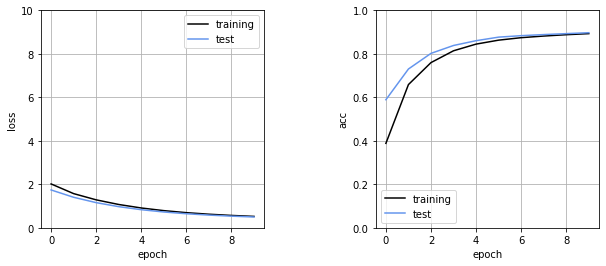

In [74]:
#-- 리스트 8-1-(6)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


plt.figure(1, figsize=(10, 4))
plt.subplots_adjust(wspace=0.5)


plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='training', color='black')
plt.plot(history.history['val_loss'], label='test',
         color='cornflowerblue')
plt.ylim(0, 10)
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='training', color='black')
plt.plot(history.history['val_accuracy'],label='test', color='cornflowerblue')
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

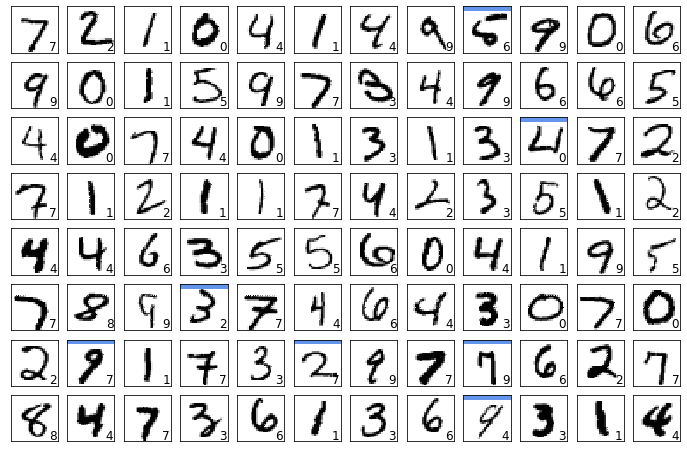

In [75]:
#-- 리스트 8-1-(7)
def show_prediction():
    n_show = 96
    y = model.predict(x_test) # (A)
    plt.figure(2, figsize=(12, 8))
    plt.gray()
    for i in range(n_show):
        plt.subplot(8, 12, i + 1)
        x = x_test[i, :]
        x = x.reshape(28, 28)
        plt.pcolor(1 - x)
        wk = y[i, :]
        prediction = np.argmax(wk)
        plt.text(22, 25.5, "%d" % prediction, fontsize=12)
        if prediction != np.argmax(y_test[i, :]):
            plt.plot([0, 27], [1, 1], color='cornflowerblue', linewidth=5)
        plt.xlim(0, 27)
        plt.ylim(27, 0)
        plt.xticks([], "")
        plt.yticks([], "")
#-- 메인
show_prediction()
plt.show()

# 8.3 ReLU 활성화 함수

시그모이드 함수는 입력 x 가 어느정도 커지면 항상 1에 가까운 값을 출력하기 때문에, 입력의 변화가 출력에 반영되기 어렵다.

그 결과 오차함수의 가중치 매개변수에 대한 편미분이 0 에 가까운 값이되어 경사 하강법의 학습이 늦어지는 문제점이 있디.

ReLU를 사용하면 입력이 양수일경우 학습의 정체 문제가 해결된다

또한 max(0,x)로 쉽게 나타낼 수 있어 계산이 빠르다

In [76]:
#-- 리스트 8-1-(8)
np.random.seed(1)
from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam


model = Sequential()
model.add(Dense(16, input_dim=784, activation='relu')) # (A)
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(), metrics=['accuracy'])


startTime = time.time()
history = model.fit(x_train, y_train, batch_size=1000, epochs=10,
                    verbose=1, validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print("Computation time:{0:.3f} sec".format(time.time() - startTime))

Epoch 1/10
60/60 [==============================] - 1s 9ms/step - loss: 1.6208 - accuracy: 0.4685 - val_loss: 0.9879 - val_accuracy: 0.7718
Epoch 2/10
60/60 [==============================] - 0s 5ms/step - loss: 0.7237 - accuracy: 0.8345 - val_loss: 0.5184 - val_accuracy: 0.8760
Epoch 3/10
60/60 [==============================] - 0s 5ms/step - loss: 0.4623 - accuracy: 0.8825 - val_loss: 0.3950 - val_accuracy: 0.8978
Epoch 4/10
60/60 [==============================] - 0s 5ms/step - loss: 0.3795 - accuracy: 0.8983 - val_loss: 0.3437 - val_accuracy: 0.9064
Epoch 5/10
60/60 [==============================] - 0s 5ms/step - loss: 0.3375 - accuracy: 0.9081 - val_loss: 0.3130 - val_accuracy: 0.9141
Epoch 6/10
60/60 [==============================] - 0s 5ms/step - loss: 0.3116 - accuracy: 0.9144 - val_loss: 0.2947 - val_accuracy: 0.9194
Epoch 7/10
60/60 [==============================] - 0s 5ms/step - loss: 0.2929 - accuracy: 0.9191 - val_loss: 0.2814 - val_accuracy: 0.9216
Epoch 8/10
60/60 [==

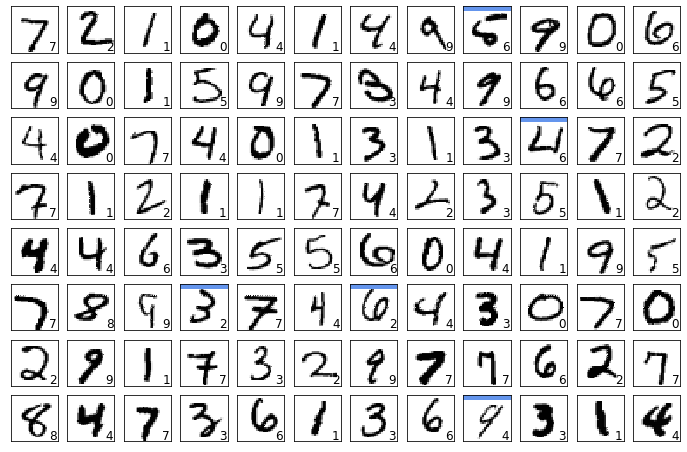

In [77]:
# 리스트 8-1-(9)
show_prediction()
plt.show()

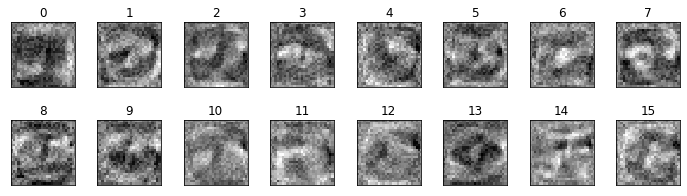

In [78]:
#-- 리스트 8-1-(10)
# 1층째의 무게 시각화
w = model.layers[0].get_weights()[0]
plt.figure(1, figsize=(12, 3))
plt.gray()
plt.subplots_adjust(wspace=0.35, hspace=0.5)
for i in range(16):
    plt.subplot(2, 8, i + 1)
    w1 = w[:, i]
    w1 = w1.reshape(28, 28)
    plt.pcolor(-w1)
    plt.xlim(0, 27)
    plt.ylim(27, 0)
    plt.xticks([], "")
    plt.yticks([], "")
    plt.title("%d" % i)
plt.show()

ReLU를 사용하였을때 네트어크가 학습 후 획득한 입력부터 중간층 뉴런까지의 가중치 이다

검은 부분은 양으값을 , 흰색 부분은 음의 값을 나타낸다.
- 검은 부분에 입력이미지가 있으면 그 유닛은 활성화 되고, 흰색 부분에 입력 이미지가 있는 유닛은 억제된다

뉴런들이 특정 숫자의 특징에 반응하는것을 볼 수 있다


정밀도를 더 높이기 위해 서는 중간층의 뉴런을 늘리는 법도 있지만 더 근본적인 문제는 2차원 이미지의 공간정보를 활용하지 않는대에 있다

네트워크의 구조가 전결합형으로 모든 입력 성분이 대등한 관계이기때문에 이웃에 있는 입력 성분도, 멀리 떨어진 입력 성분도 수식상으로는 똑같은 관계이기 때문에 공간정보가 사용되고 있지 않는 것이다

## 8.4 공간필터

이미지의 일부분과 필터의 요소곱을 곱한 합을, 이미지에 슬라이드 시키면서 이미지의 전 영역에서 구한다. 

이러한 계산을 합성곱 연산이라고 한다

원본 이미지의 위치를 i,j 의 픽셀값을 x(i,j), 3 * 3의 필터를 h(i,j)로 하면 합성곱 연산에서 얻어지는 값 g(i,j)는

$$g(i,j) = \sum_{u=-1}^1 \sum_{v=-1}^1 x(i+u,j+v)h(u+1,v+1)$$

이 된다

필터의 크기는임의로 설정할 수 있지만 중심을 결정할 수 있는 홀수너비가 사용하기 쉬울것이다

In [79]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [80]:
#-- 리스트 8-2-(1)
import numpy as np
from keras.datasets import mnist
from keras.utils import np_utils
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
num_classes = 10
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

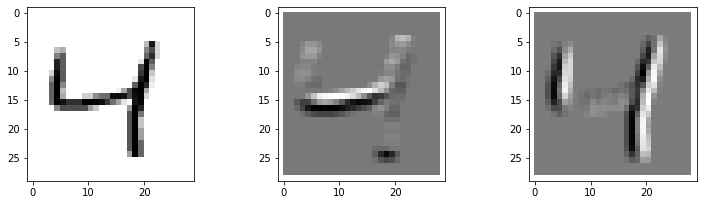

In [81]:
#-- 리스트 8-2-(2)
import matplotlib.pyplot as plt
%matplotlib inline


id_img = 2
myfil1 = np.array([[1, 1, 1],
                   [1, 1, 1],
                   [-2, -2, -2]], dtype=float) # (A)
myfil2 = np.array([[-2, 1, 1],
                   [-2, 1, 1],
                   [-2, 1, 1]], dtype=float) # (B)


x_img = x_train[id_img, :, :, 0]
img_h = 28
img_w = 28
x_img = x_img.reshape(img_h, img_w)
out_img1 = np.zeros_like(x_img)
out_img2 = np.zeros_like(x_img)

# 필터 처리
for ih in range(img_h - 3):
    for iw in range(img_w - 3):
        img_part = x_img[ih:ih + 3, iw:iw + 3]
        out_img1[ih + 1, iw + 1] = \
            np.dot(img_part.reshape(-1), myfil1.reshape(-1))
        out_img2[ih + 1, iw + 1] = \
            np.dot(img_part.reshape(-1), myfil2.reshape(-1)) 


# - 표시
plt.figure(1, figsize=(12, 3.2))
plt.subplots_adjust(wspace=0.5)
plt.gray()
plt.subplot(1, 3, 1)
plt.pcolor(1 - x_img)
plt.xlim(-1, 29)
plt.ylim(29, -1)
plt.subplot(1, 3, 2)
plt.pcolor(-out_img1)
plt.xlim(-1, 29)
plt.ylim(29, -1)
plt.subplot(1, 3, 3)
plt.pcolor(-out_img2)
plt.xlim(-1, 29)
plt.ylim(29, -1)
plt.show()

필터를 적용하면 출력 이미지의 크기는 작아진다.

이것에 대응하여 패딩(padding)이라는 방법을 사용한다.

패딩은 필터를 적용하기 전에 0등의 고정된 요소로 주위를 부풀려두는 방법이다.


스트라이드는 필터의 이동 칸수를 정해준다


필터의 크기, 패딩, 스트라이드 값을 이용하여 출력이미지의 크기를 고려한다

## 8.5 합성곱 신경망

In [82]:
#-- 리스트 8-2-(3)
import numpy as np
np.random.seed(1)
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import time


model = Sequential()
model.add(Conv2D(8, (3, 3), padding='same',
                 input_shape=(28, 28, 1), activation='relu')) # (A)
model.add(Flatten()) # (B)
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
startTime = time.time()
history = model.fit(x_train, y_train, batch_size=1000, epochs=20,
                    verbose=1, validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print("Computation time:{0:.3f} sec".format(time.time() - startTime))

Epoch 1/20
60/60 [==============================] - 5s 74ms/step - loss: 0.8481 - accuracy: 0.8025 - val_loss: 0.3604 - val_accuracy: 0.9007
Epoch 2/20
60/60 [==============================] - 4s 71ms/step - loss: 0.3311 - accuracy: 0.9054 - val_loss: 0.2883 - val_accuracy: 0.9184
Epoch 3/20
60/60 [==============================] - 4s 70ms/step - loss: 0.2864 - accuracy: 0.9187 - val_loss: 0.2652 - val_accuracy: 0.9253
Epoch 4/20
60/60 [==============================] - 4s 69ms/step - loss: 0.2644 - accuracy: 0.9252 - val_loss: 0.2500 - val_accuracy: 0.9301
Epoch 5/20
60/60 [==============================] - 4s 69ms/step - loss: 0.2438 - accuracy: 0.9319 - val_loss: 0.2344 - val_accuracy: 0.9351
Epoch 6/20
60/60 [==============================] - 4s 69ms/step - loss: 0.2245 - accuracy: 0.9376 - val_loss: 0.2167 - val_accuracy: 0.9404
Epoch 7/20
60/60 [==============================] - 4s 69ms/step - loss: 0.2060 - accuracy: 0.9439 - val_loss: 0.1995 - val_accuracy: 0.9447
Epoch 8/20
60

In [83]:
#-- 리스트 8-1-(7)
def show_prediction():
    n_show = 96
    y = model.predict(x_test) # (A)
    plt.figure(2, figsize=(12, 8))
    plt.gray()
    for i in range(n_show):
        plt.subplot(8, 12, i + 1)
        x = x_test[i, :]
        x = x.reshape(28, 28)
        plt.pcolor(1 - x)
        wk = y[i, :]
        prediction = np.argmax(wk)
        plt.text(22, 25.5, "%d" % prediction, fontsize=12)
        if prediction != np.argmax(y_test[i, :]):
            plt.plot([0, 27], [1, 1], color='cornflowerblue', linewidth=5)
        plt.xlim(0, 27)
        plt.ylim(27, 0)
        plt.xticks([], "")
        plt.yticks([], "")

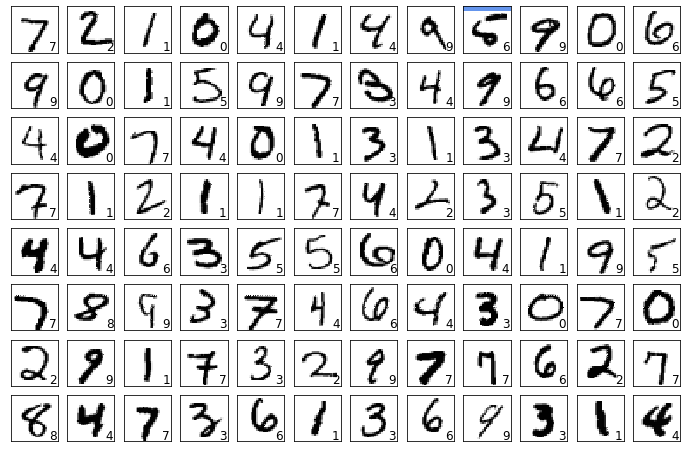

In [84]:
# 리스트 8-2-(4)
show_prediction()
plt.show()

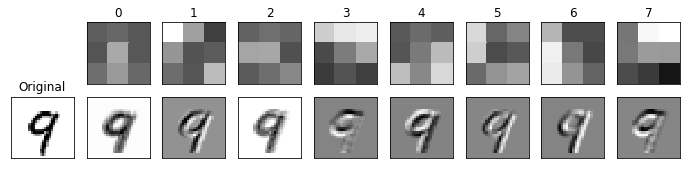

In [85]:
# 리스트 8-2-(5)
plt.figure(1, figsize=(12, 2.5))
plt.gray()
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.subplot(2, 9, 10)
id_img = 12
x_img = x_test[id_img, :, :, 0]
img_h = 28
img_w = 28
x_img = x_img.reshape(img_h, img_w)
plt.pcolor(-x_img)
plt.xlim(0, img_h)
plt.ylim(img_w, 0)
plt.xticks([], "")
plt.yticks([], "")
plt.title("Original")


w = model.layers[0].get_weights()[0] # (A)
max_w = np.max(w)
min_w = np.min(w)
for i in range(8):
    plt.subplot(2, 9, i + 2)
    w1 = w[:, :, 0, i]
    w1 = w1.reshape(3, 3)
    plt.pcolor(-w1, vmin=min_w, vmax=max_w)
    plt.xlim(0, 3)
    plt.ylim(3, 0)
    plt.xticks([], "")
    plt.yticks([], "")
    plt.title("%d" % i)
    plt.subplot(2, 9, i + 11)
    out_img = np.zeros_like(x_img)
    # 필터 처리
    for ih in range(img_h - 3):
        for iw in range(img_w - 3):
            img_part = x_img[ih:ih + 3, iw:iw + 3]
            out_img[ih + 1, iw + 1] = \
            np.dot(img_part.reshape(-1), w1.reshape(-1))
    plt.pcolor(-out_img)
    plt.xlim(0, img_w)
    plt.ylim(img_h, 0)
    plt.xticks([], "")
    plt.yticks([], "")
plt.show()

## 8.6 풀링

합성곱층은 2차원 이미지가 가지는 특징을 이용할 수 있었었다.

이미지 인식과 관련하여 이미지의 위치의 어긋남에대한 견고성또한 중요하다.

이 문제를 해결하는 방법으로 풀링처리가 있다

풀링은 합성곱층 데이터의 공간적 크기를 축소하는데 사용된다.

이렇게하여 얻은 출력 이미지는 입력 이미지가 가로 세로로 어긋나도 거의 변하지 않는 성질을 갖는다

## 8.7 드롭아웃

드롭아웃은 학습 시에 입력층의 유닛과 중간층 뉴런을 확률 p(p<1)로 임의로 선택하여, 나머지를 모두 무효화 하는 방법이다.

무효화된 뉴런은 존재하지 않는것으로 하여 학습을 갱신한다

미니배치마다 뉴런을 뽑아 다시 이 절차를 반복한다

예측을 하는 경우에는 모든 뉴런이 사용된다

학습 시에는 p의 비율의 뉴런밖에 존재하지 않는 상태에서 학습하고 있었는데, 예측시에 전체 참가가 되면 출력이 커져버린다 (1/p qo)

따라서 예측시에는 드롭아웃을 한 층의 출력대상의 가중치를 p배로 하여(p는 1 이하이므로 줄어들게 된다) 계산을 맞춘다.

드롭아웃은 여러 네트워크를 각각 학습시켜 예측시에 네트워크를 평균화해 합치는 효과가 있다

## MNIST 인식 네트워크 모델

In [86]:
# 리스트 8-2-(6)
import numpy as np
np.random.seed(1)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import time


model = Sequential()
model.add(Conv2D(16, (3, 3),
                 input_shape=(28, 28, 1), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # (A)
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # (B)
model.add(Dropout(0.25)) # (C)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25)) # (D)
model.add(Dense(num_classes, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])


startTime = time.time()


history = model.fit(x_train, y_train, batch_size=1000, epochs=20,
                    verbose=1, validation_data=(x_test, y_test))


score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print("Computation time:{0:.3f} sec".format(time.time() - startTime))


Epoch 1/20
60/60 [==============================] - 37s 608ms/step - loss: 0.6704 - accuracy: 0.7957 - val_loss: 0.1198 - val_accuracy: 0.9620
Epoch 2/20
60/60 [==============================] - 36s 600ms/step - loss: 0.1284 - accuracy: 0.9610 - val_loss: 0.0653 - val_accuracy: 0.9799
Epoch 3/20
60/60 [==============================] - 36s 606ms/step - loss: 0.0842 - accuracy: 0.9743 - val_loss: 0.0430 - val_accuracy: 0.9859
Epoch 4/20
60/60 [==============================] - 37s 614ms/step - loss: 0.0662 - accuracy: 0.9798 - val_loss: 0.0363 - val_accuracy: 0.9879
Epoch 5/20
60/60 [==============================] - 36s 606ms/step - loss: 0.0549 - accuracy: 0.9832 - val_loss: 0.0313 - val_accuracy: 0.9901
Epoch 6/20
60/60 [==============================] - 37s 610ms/step - loss: 0.0476 - accuracy: 0.9854 - val_loss: 0.0266 - val_accuracy: 0.9913
Epoch 7/20
60/60 [==============================] - 37s 620ms/step - loss: 0.0407 - accuracy: 0.9872 - val_loss: 0.0260 - val_accuracy: 0.9909

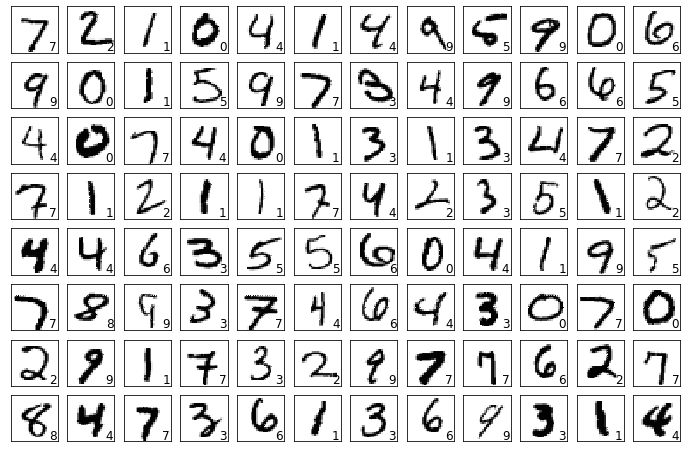

In [87]:
# 리스트 8-2-(7)
show_prediction()
plt.show()